In [1]:
import pandas as pd
import numpy as np

In [2]:
path = 'c:/data/elo/'
train_path = 'train.csv'
test_path = 'test.csv'
historical_transactions_path = 'historical_transactions.csv'
new_merchant_transactions_path = 'new_merchant_transactions.csv'
merchants_path= 'merchants.csv'

In [3]:
%matplotlib inline

In [4]:
import telepot
def send_notify(text):
    with open('../../_access_keys/telegram_token.txt', 'r') as content_file:
        token = content_file.read()
    with open('../../_access_keys/user.txt', 'r') as content_file:
        user = content_file.read()
    try:
        TelegramBot = telepot.Bot(token)
        TelegramBot.sendMessage(int(user), text)
    except:
        pass

In [5]:
from keras.callbacks import Callback
from matplotlib import pyplot as plt
from IPython.display import clear_output
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(15,10))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="validation loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from datetime import datetime

In [7]:
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, GlobalMaxPooling1D, GRU, Bidirectional, LSTM, concatenate
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import regularizers

In [9]:
import lightgbm as lgb

# analyze

In [10]:
train = pd.read_csv(path + train_path)

In [11]:
train.shape

(201917, 6)

In [12]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [13]:
train['feature_3'].unique()

array([1, 0], dtype=int64)

In [14]:
train['is_train'] = True

In [15]:
test = pd.read_csv(path + test_path)

In [16]:
test.shape

(123623, 5)

In [17]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [18]:
test['target'] = np.nan
test['is_train'] = False

In [19]:
train_test = pd.concat((train, test))

In [34]:
train_test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,is_train,count_month
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,True,-245.0
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,True,-396.0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,True,-549.0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,True,-153.0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,True,-92.0


In [26]:
train_test['first_active_month'] = train_test['first_active_month'].apply(pd.to_datetime)

In [30]:
max_date = train_test['first_active_month'].max()

In [33]:
train_test['count_month'] = train_test['first_active_month'] - max_date
train_test['count_month'] = train_test['count_month'].apply(lambda x:x.days)

## historical_transactions 

In [20]:
historical_transactions = pd.read_csv(path + historical_transactions_path)

In [21]:
historical_transactions.shape

(29112361, 14)

In [22]:
historical_transactions.head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37


In [23]:
#historical_transactions['subsector_id'].value_counts()

In [24]:
historical_transactions['category_1'].replace({'N':0, 'Y':1}, inplace=True)
historical_transactions['category_3'].replace({'A':0, 'B':1, 'C':2}, inplace=True)
historical_transactions['authorized_flag'].replace({'N':0, 'Y':1}, inplace=True)

In [36]:
sum_purchases = historical_transactions.groupby(['card_id', 'authorized_flag']).agg({'purchase_amount': [min, max, sum, np.median, np.std, 'count', np.mean]}).reset_index()
sum_purchases.columns = ['authorized_flag_' + '_'.join(x) if x[1] != '' else x[0] for x in sum_purchases.columns.ravel()]
sum_purchases.head(1)

,card_id,authorized_flag,authorized_flag_purchase_amount_min,authorized_flag_purchase_amount_max,authorized_flag_purchase_amount_sum,authorized_flag_purchase_amount_median,authorized_flag_purchase_amount_std,authorized_flag_purchase_amount_count,authorized_flag_purchase_amount_mean
0,C_ID_00007093c1,0,-0.728876,1.507069,-14.401965,-0.569219,0.430059,35,-0.411485


In [25]:
aggregate_columns = ['category_1', 'installments', 'category_3', 'merchant_category_id',\
                     'category_2', 'state_id', 'subsector_id']
aggregates_history = []
for c in aggregate_columns:
    for i in historical_transactions[c].unique():
        part_historical_transactions = historical_transactions[historical_transactions[c] == i]
        aggregate_item = part_historical_transactions.groupby(['card_id', 'authorized_flag'])\
            .agg({'purchase_amount': [min, max, sum, np.median, np.std, 'count', np.mean]}).reset_index()
        aggregate_item.columns = [c + '_' + str(i) + '_' + '_'.join(x) if x[1] != '' else x[0] for x in aggregate_item.columns.ravel()]
        aggregates_history.append(aggregate_item)
        print(c, i)

category_1 0
category_1 1
installments 0
installments 1
installments 5
installments 3
installments 4
installments 2
installments -1
installments 10
installments 6
installments 12
installments 8
installments 7
installments 9
installments 11
installments 999
category_3 0.0
category_3 1.0
category_3 2.0
category_3 nan
merchant_category_id 80
merchant_category_id 367
merchant_category_id 560
merchant_category_id 278
merchant_category_id 683
merchant_category_id 130
merchant_category_id 879
merchant_category_id 511
merchant_category_id 842
merchant_category_id 561
merchant_category_id 705
merchant_category_id 332
merchant_category_id 111
merchant_category_id 528
merchant_category_id 437
merchant_category_id 605
merchant_category_id 387
merchant_category_id 19
merchant_category_id 307
merchant_category_id 333
merchant_category_id 506
merchant_category_id 108
merchant_category_id 45
merchant_category_id 813
merchant_category_id 755
merchant_category_id 290
merchant_category_id 68
merchant_cat

merchant_category_id 523
merchant_category_id 603
merchant_category_id 145
merchant_category_id 882
merchant_category_id 322
merchant_category_id 18
merchant_category_id 875
merchant_category_id 687
merchant_category_id 86
merchant_category_id 266
category_2 1.0
category_2 nan
category_2 3.0
category_2 5.0
category_2 2.0
category_2 4.0
state_id 16
state_id 9
state_id -1
state_id 11
state_id 15
state_id 17
state_id 5
state_id 24
state_id 19
state_id 23
state_id 3
state_id 8
state_id 18
state_id 7
state_id 4
state_id 22
state_id 13
state_id 1
state_id 10
state_id 21
state_id 20
state_id 14
state_id 2
state_id 12
state_id 6
subsector_id 37
subsector_id 16
subsector_id 34
subsector_id 41
subsector_id 29
subsector_id 7
subsector_id 33
subsector_id 2
subsector_id 36
subsector_id 25
subsector_id 15
subsector_id 19
subsector_id 10
subsector_id 30
subsector_id 18
subsector_id 8
subsector_id 27
subsector_id 1
subsector_id 39
subsector_id 32
subsector_id 22
subsector_id 20
subsector_id 21
subsect

In [26]:
cities = historical_transactions['city_id'].unique()
category_1 = historical_transactions['category_1'].unique()
category_3 = historical_transactions['category_3'].unique()
merchant_category_id = historical_transactions['merchant_category_id'].unique()
category_2 = historical_transactions['category_2'].unique()
state_id = historical_transactions['state_id'].unique()
subsector_id = historical_transactions['subsector_id'].unique()

## new_merchant_transactions 

In [27]:
new_merchant_transactions = pd.read_csv(path + new_merchant_transactions_path)

In [28]:
new_merchant_transactions.shape

(1963031, 14)

In [29]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [30]:
new_merchant_transactions.drop('authorized_flag', axis=1, inplace=True)

In [31]:
new_merchant_transactions['category_1'].replace({'N':0, 'Y':1}, inplace=True)

In [32]:
new_merchant_transactions['category_1'].value_counts()

0    1899935
1      63096
Name: category_1, dtype: int64

## merchants 

In [33]:
merchants = pd.read_csv(path + merchants_path)

In [34]:
merchants.shape

(334696, 22)

In [35]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [36]:
merchants['most_recent_sales_range'].unique()

array(['E', 'C', 'D', 'A', 'B'], dtype=object)

## processing

In [37]:
data = train_test.merge(sum_purchases[sum_purchases['authorized_flag'] == 0].drop(['authorized_flag'], axis=1), how='left', left_on='card_id', right_on='card_id')
data = data.merge(sum_purchases[sum_purchases['authorized_flag'] == 1].drop(['authorized_flag'], axis=1), how='left', left_on='card_id', right_on='card_id')

In [38]:
count_aggregates_history = len(aggregates_history)
aggregates_history_10 = []
item_10 = None
for _item in enumerate(aggregates_history):
    index = _item[0]
    if index % 30 == 0:
        if item_10 is not None:
            aggregates_history_10.append(item_10)
        item_10 = None
    item = _item[1]
    if item_10 is None:
        item_10 = pd.DataFrame(data[['card_id']], columns=['card_id'])
    item_10 = item_10.merge(item[item['authorized_flag'] == 0].drop(['authorized_flag'], axis=1), how='left', left_on='card_id', right_on='card_id')
    item_10 = item_10.merge(item[item['authorized_flag'] == 1].drop(['authorized_flag'], axis=1), how='left', left_on='card_id', right_on='card_id')
    print(index, '/', count_aggregates_history)
aggregates_history_10.append(item_10)

0 / 420
1 / 420
2 / 420
3 / 420
4 / 420
5 / 420
6 / 420
7 / 420
8 / 420
9 / 420
10 / 420
11 / 420
12 / 420
13 / 420
14 / 420
15 / 420
16 / 420
17 / 420
18 / 420
19 / 420
20 / 420
21 / 420
22 / 420
23 / 420
24 / 420
25 / 420
26 / 420
27 / 420
28 / 420
29 / 420
30 / 420
31 / 420
32 / 420
33 / 420
34 / 420
35 / 420
36 / 420
37 / 420
38 / 420
39 / 420
40 / 420
41 / 420
42 / 420
43 / 420
44 / 420
45 / 420
46 / 420
47 / 420
48 / 420
49 / 420
50 / 420
51 / 420
52 / 420
53 / 420
54 / 420
55 / 420
56 / 420
57 / 420
58 / 420
59 / 420
60 / 420
61 / 420
62 / 420
63 / 420
64 / 420
65 / 420
66 / 420
67 / 420
68 / 420
69 / 420
70 / 420
71 / 420
72 / 420
73 / 420
74 / 420
75 / 420
76 / 420
77 / 420
78 / 420
79 / 420
80 / 420
81 / 420
82 / 420
83 / 420
84 / 420
85 / 420
86 / 420
87 / 420
88 / 420
89 / 420
90 / 420
91 / 420
92 / 420
93 / 420
94 / 420
95 / 420
96 / 420
97 / 420
98 / 420
99 / 420
100 / 420
101 / 420
102 / 420
103 / 420
104 / 420
105 / 420
106 / 420
107 / 420
108 / 420
109 / 420
110 / 420


In [43]:
count_aggregates_history = len(aggregates_history_10)
for _item in enumerate(aggregates_history_10):
    index = _item[0]
    item = _item[1]
    data = data.merge(item, how='left', left_on='card_id', right_on='card_id')
    print(index, '/', count_aggregates_history)

0 / 14
1 / 14
2 / 14
3 / 14
4 / 14
5 / 14
6 / 14
7 / 14
8 / 14
9 / 14
10 / 14
11 / 14
12 / 14
13 / 14


In [44]:
data.to_csv(path + 'data.csv', index=False)

In [10]:
data = pd.read_csv(path + 'data.csv')

In [11]:
data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,is_train,authorized_flag_purchase_amount_min_x,authorized_flag_purchase_amount_max_x,authorized_flag_purchase_amount_sum_x,...,subsector_id_28_purchase_amount_std_x,subsector_id_28_purchase_amount_count_x,subsector_id_28_purchase_amount_mean_x,subsector_id_28_purchase_amount_min_y,subsector_id_28_purchase_amount_max_y,subsector_id_28_purchase_amount_sum_y,subsector_id_28_purchase_amount_median_y,subsector_id_28_purchase_amount_std_y,subsector_id_28_purchase_amount_count_y,subsector_id_28_purchase_amount_mean_y
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,True,-0.737892,-0.431922,-8.571723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,True,-0.740897,1.942838,-1.122886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,True,-0.701453,-0.637515,-1.338967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,True,-0.512945,7.193041,20.352809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
target_columns = [str(i) for i in data.columns]
target_columns.remove('target')
target_columns.remove('is_train')
target_columns.remove('card_id')
target_columns.remove('first_active_month')

In [39]:
scaler_columns = target_columns
learn_columns = []
for i in enumerate(scaler_columns):
    index = i[0]
    column = i[1]
    min_data = data[column].min()
    if (min_data is None or np.isnan(min_data)):
        print(column, ' is nan')
        continue
    data[column].fillna(min_data, inplace=True)
    data[column] -= min_data
    data[column] /= data[column].max()
    print(index, '/', len(scaler_columns))
    learn_columns.append(column)

0 / 18
1 / 18
2 / 18
3 / 18
4 / 18
5 / 18
6 / 18
7 / 18
8 / 18
9 / 18
10 / 18
11 / 18
12 / 18
13 / 18
14 / 18
15 / 18
16 / 18
17 / 18


# train

In [40]:
y = data[data['is_train']]['target']

In [41]:
X = data[data['is_train']][learn_columns]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
X.shape, X.dropna().shape

((201917, 18), (201917, 18))

In [44]:
gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 3,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.1,
                            n_estimators = 300)

In [45]:
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=5)

[1]	valid_0's l2: 15.0098	valid_0's rmse: 3.87424
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 14.9949	valid_0's rmse: 3.87232
[3]	valid_0's l2: 14.9811	valid_0's rmse: 3.87054
[4]	valid_0's l2: 14.9729	valid_0's rmse: 3.86948
[5]	valid_0's l2: 14.9629	valid_0's rmse: 3.86819
[6]	valid_0's l2: 14.9567	valid_0's rmse: 3.86739
[7]	valid_0's l2: 14.9483	valid_0's rmse: 3.8663
[8]	valid_0's l2: 14.9424	valid_0's rmse: 3.86554
[9]	valid_0's l2: 14.9384	valid_0's rmse: 3.86503
[10]	valid_0's l2: 14.9356	valid_0's rmse: 3.86466
[11]	valid_0's l2: 14.9312	valid_0's rmse: 3.8641
[12]	valid_0's l2: 14.9297	valid_0's rmse: 3.8639
[13]	valid_0's l2: 14.9262	valid_0's rmse: 3.86344
[14]	valid_0's l2: 14.9242	valid_0's rmse: 3.86319
[15]	valid_0's l2: 14.9219	valid_0's rmse: 3.86288
[16]	valid_0's l2: 14.9208	valid_0's rmse: 3.86275
[17]	valid_0's l2: 14.9186	valid_0's rmse: 3.86246
[18]	valid_0's l2: 14.916	valid_0's rmse: 3.86213
[19]	valid_0's l2: 14.9153	valid_0

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
       max_depth=3, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0)

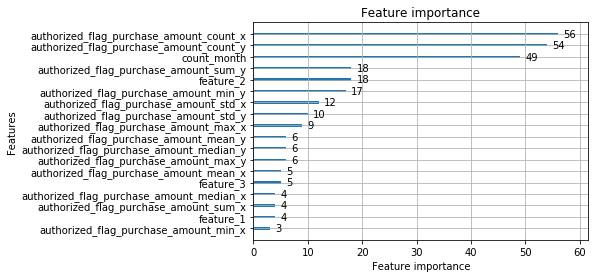

In [46]:
%matplotlib inline
lgb.plot_importance(gbm)

In [48]:
feature_importances = []
for i in zip(gbm.feature_importances_, learn_columns):
    if i[0] != 0:
        print(i[1], i[0])
        feature_importances.append(i[1])

feature_1 4
feature_2 18
feature_3 5
count_month 49
authorized_flag_purchase_amount_min_x 3
authorized_flag_purchase_amount_max_x 9
authorized_flag_purchase_amount_sum_x 4
authorized_flag_purchase_amount_median_x 4
authorized_flag_purchase_amount_std_x 12
authorized_flag_purchase_amount_count_x 56
authorized_flag_purchase_amount_mean_x 5
authorized_flag_purchase_amount_min_y 17
authorized_flag_purchase_amount_max_y 6
authorized_flag_purchase_amount_sum_y 18
authorized_flag_purchase_amount_median_y 6
authorized_flag_purchase_amount_std_y 10
authorized_flag_purchase_amount_count_y 54
authorized_flag_purchase_amount_mean_y 6


In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [51]:
X_val = data[~data['is_train']][learn_columns]

In [52]:
predict = gbm.predict(X_val)

In [53]:
pd.DataFrame({'card_id':list(data[~data['is_train']]['card_id']), 'target':predict}).to_csv('output/predict_{}.csv'.format(datetime.now().strftime("%Y-%m-%d_%H_%M_%S")), index=False)

In [54]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [75]:
def create_model():
    #build Keras model
    
    x_input = Input(shape=X_train.shape[1:], dtype='float32')

    x_layer = Dense(X_train.shape[-1])(x_input)
    x_layer = Dense(1)(x_layer)
    

    model = Model(x_input, x_layer)
    model.compile(loss='mse', metrics=['mae'], optimizer='rmsprop')
    return model

In [76]:
count_epochs = 100
model = create_model()
early_stopping_monitor = EarlyStopping(patience=10)
history = model.fit(np.array(X_train), np.array(y_train), batch_size = 128, epochs = count_epochs, verbose=1, validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 129226 samples, validate on 32307 samples
Epoch 1/100
129226/129226 [==============================] - 1s 11us/step - loss: 14.8764 - mean_absolute_error: 1.5967 - val_loss: 14.5362 - val_mean_absolute_error: 1.5652
Epoch 2/100
129226/129226 [==============================] - 1s 9us/step - loss: 14.8131 - mean_absolute_error: 1.5905 - val_loss: 14.5237 - val_mean_absolute_error: 1.5778
Epoch 3/100
129226/129226 [==============================] - 1s 9us/step - loss: 14.8024 - mean_absolute_error: 1.5921 - val_loss: 14.5236 - val_mean_absolute_error: 1.6029
Epoch 4/100
129226/129226 [==============================] - 1s 9us/step - loss: 14.7958 - mean_absolute_error: 1.5933 - val_loss: 14.5121 - val_mean_absolute_error: 1.5905
Epoch 5/100
129226/129226 [==============================] - 1s 9us/step - loss: 14.7911 - mean_absolute_error: 1.5945 - val_loss: 14.5367 - val_mean_absolute_error: 1.6337
Epoch 6/100
129226/129226 [==============================] - 1s 9us/step - loss: 14

In [ ]:
send_notify('complete')

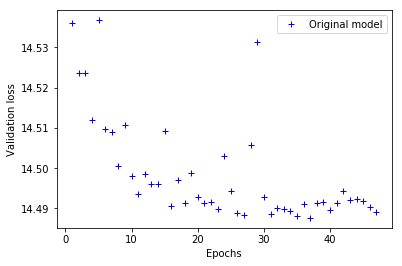

In [77]:
history_gr = history.history['val_loss']
epochs = range(1, len(history_gr) + 1)
import matplotlib.pyplot as plt

plt.plot(epochs, history_gr, 'b+', label='Original model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [78]:
model.evaluate(np.array(X_test), np.array(y_test))

40384/40384 [==============================] - 1s 20us/step


[14.93929274136971, 1.6032354537450757]

In [79]:
X_val = data[~data['is_train']][learn_columns]

In [80]:
predict = model.predict(np.array(X_val))

In [81]:
predict = gbm.predict(X_val)

In [82]:
pd.DataFrame({'card_id':list(data[~data['is_train']]['card_id']), 'target':predict.reshape(len(predict))}).to_csv('output/predict_{}.csv'.format(datetime.now().strftime("%Y-%m-%d_%H_%M_%S")), index=False)